In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

In [233]:
provider = pd.read_csv('Train-1542865627584.csv')
bene = pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
inpatient = pd.read_csv('Train_Inpatientdata-1542865627584.csv')
outpatient = pd.read_csv('Train_Outpatientdata-1542865627584.csv')

In [234]:
inpatient['patient_type'] = 'inpatient'
outpatient['patient_type'] = 'outpatient'

In [235]:
patients = pd.concat([inpatient,outpatient], axis = 0)

In [236]:
merged_data = patients.merge(bene, how = 'left', on = 'BeneID')

In [237]:
final_patients = merged_data.merge(provider, how = 'left', on = 'Provider')

In [238]:
#making a copy of merged data
patient_record = final_patients.copy()

## Changing into DateTime 

In [239]:
patient_record[['DOB', 'ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']] = \
    patient_record[['DOB', 'ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']].apply(pd.to_datetime, 
                                                                                               format ='%Y-%m-%d')

## Total number of patients and type of patient(inpatient, outpatient, both)

In [240]:
total = patient_record.groupby(['Provider', 'BeneID'])['BeneID'].count().reset_index(name = 'patient_count')
total = total.groupby('Provider')['patient_count'].count().reset_index()
provider2 = provider.merge(total, how = 'left', on = 'Provider')

In [241]:
inpatient_list = patient_record[patient_record['patient_type'] == 'inpatient'].Provider.to_list()
outpatient_list = patient_record[patient_record['patient_type'] == 'outpatient'].Provider.to_list()

In [242]:
common_patient = set(inpatient_list) & set(outpatient_list)

In [243]:
patient_record.loc[patient_record.Provider.isin(common_patient), 'common_patient'] = 'Both'
patient_record.loc[~patient_record.Provider.isin(common_patient), 'common_patient'] = 0

In [244]:
patient_record['patient_type'].mask(patient_record['common_patient'] == 'Both', 'both', inplace = True)

In [245]:
patient_type = patient_record[['Provider', 'patient_type']]

In [246]:
provider2 = provider2.merge(patient_type, how = 'left', on = 'Provider')

In [247]:
provider2.drop_duplicates(subset = ['Provider'],keep = 'first', inplace = True)

In [248]:
provider2.head(5)

,Provider,PotentialFraud,patient_count,patient_type
0,PRV51001,No,24,both
25,PRV51003,Yes,117,both
157,PRV51004,No,138,outpatient
306,PRV51005,Yes,495,outpatient
1471,PRV51007,No,58,both


## Race

In [249]:
race = patient_record.groupby(['Provider', 'BeneID', 'Race'])['Race'].count().reset_index(name = 'race_count')

In [250]:
race.head()

,Provider,BeneID,Race,race_count
0,PRV51001,BENE102690,1,1
1,PRV51001,BENE106078,1,1
2,PRV51001,BENE11727,1,1
3,PRV51001,BENE123416,1,1
4,PRV51001,BENE126477,1,1


In [251]:
race2 = race.groupby(['Provider', 'Race'])['race_count'].count().reset_index(name = 'race_count1')

In [252]:
race2 = race2.pivot(index = 'Provider', columns = 'Race', values = 'race_count1')

In [253]:
race2.columns = ['Race1', 'Race2', 'Race3', 'Race5']

In [254]:
provider2 = provider2.merge(race2, how = 'left', on = 'Provider')

In [255]:
provider2[['Race1', 'Race2', 'Race3', 'Race5']] = provider2[['Race1', 'Race2', 'Race3', 'Race5']].fillna(0)

## Gender

In [256]:
gender = patient_record.groupby(['Provider', 'BeneID','Gender'])['Gender'].count().reset_index(name = 'gender_count')


In [257]:
gender2 = gender.groupby(['Provider', 'Gender'])['gender_count'].count().reset_index(name = 'gender_count1')

In [258]:
gender2 = gender2.pivot(index = 'Provider', columns = 'Gender', values = 'gender_count1')

In [259]:
gender2.columns = ['Male', 'Female']

In [260]:
provider2

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0
...,...,...,...,...,...,...,...,...
5405,PRV57759,No,24,outpatient,19.0,1.0,0.0,4.0
5406,PRV57760,No,9,outpatient,7.0,2.0,0.0,0.0
5407,PRV57761,No,67,outpatient,58.0,5.0,1.0,3.0
5408,PRV57762,No,1,outpatient,1.0,0.0,0.0,0.0


In [261]:
provider2 = provider2.merge(gender2, how = 'left', on = 'Provider')

In [262]:
provider2[['Male', 'Female']] = provider2[['Male', 'Female']].fillna(0)

## Age

In [263]:
patient_record['Age'] = patient_record['ClaimStartDt'].dt.year.astype(int) - patient_record['DOB'].dt.year.astype(int)

In [264]:
age = patient_record.groupby(['Provider'])['Age'].mean().reset_index(name = 'mean_age').round()

In [265]:
age

,Provider,mean_age
0,PRV51001,78.0
1,PRV51003,70.0
2,PRV51004,72.0
3,PRV51005,70.0
4,PRV51007,69.0
...,...,...
5405,PRV57759,73.0
5406,PRV57760,61.0
5407,PRV57761,71.0
5408,PRV57762,67.0


In [266]:
provider2 = provider2.merge(age, how = 'left', on = 'Provider')

In [267]:
provider2.head(2)

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0


## State

In [268]:
state = patient_record.groupby(['Provider', 'State'])['State'].count().reset_index(name = 'state_count')
state = state.groupby('Provider')['state_count'].count().reset_index()

In [269]:
provider2 = provider2.merge(state, how = 'left', on = 'Provider')

In [270]:
provider2.head(2)

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3


## Physician

In [271]:
Att_phy = patient_record.groupby(['Provider', 'AttendingPhysician'])['AttendingPhysician'].count()\
.reset_index(name = 'phy_count')

In [272]:
Att_phy = Att_phy.groupby('Provider')['phy_count'].count().reset_index()

In [273]:
provider2 = provider2.merge(Att_phy, how = 'left', on = 'Provider')

In [274]:
provider2.head(8)

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10
5,PRV51008,No,36,both,28.0,8.0,0.0,0.0,16.0,20.0,75.0,2,10
6,PRV51011,No,53,both,46.0,7.0,0.0,0.0,24.0,29.0,74.0,1,28
7,PRV51012,No,31,outpatient,25.0,6.0,0.0,0.0,8.0,23.0,74.0,3,14


In [275]:
patient_record['noPhysician'] = patient_record[['AttendingPhysician','OperatingPhysician', 'OtherPhysician']]\
                                .isna().all(axis =1)


In [276]:
no_phy = patient_record.groupby(['Provider'])['noPhysician'].sum().reset_index(name = 'no_phy')

In [277]:
provider2 = provider2.merge(no_phy, how = 'left', on = 'Provider')

## Chronic condition

In [278]:
patient_record.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'patient_type', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depressi

In [279]:
patient_record[['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 
                 'ClmProcedureCode_5', 'ClmDiagnosisCode_6','ClmDiagnosisCode_1','ClmDiagnosisCode_2', 
                 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4','ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 
                 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8','ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 
                 'DeductibleAmtPaid' ]] = \
patient_record[['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 
                 'ClmProcedureCode_5', 'ClmDiagnosisCode_6','ClmDiagnosisCode_1','ClmDiagnosisCode_2', 
                 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4','ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 
                 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8','ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 
                 'DeductibleAmtPaid' ]].fillna(0)

In [280]:
#Change the chronic condition to 1 or 0 encoding from 1, 2

patient_record = patient_record.replace({'ChronicCond_Alzheimer' :2, 'ChronicCond_Heartfailure' : 2, 
                                         'ChronicCond_KidneyDisease' :2,'ChronicCond_Cancer' :2, 
                                         'ChronicCond_ObstrPulmonary' :2 ,'ChronicCond_Depression' :2,
                                        'ChronicCond_Diabetes' :2, 'ChronicCond_IschemicHeart' :2,
                                         'ChronicCond_Osteoporasis' :2, 'ChronicCond_rheumatoidarthritis' :2,
                                        'ChronicCond_stroke' :2}, 0)


In [281]:
patient_record['RenalDiseaseIndicator'].value_counts()

0    448363
Y    109848
Name: RenalDiseaseIndicator, dtype: int64

In [282]:
#change the renal disease indicator in binary encoding(0,1)
patient_record = patient_record.replace({'RenalDiseaseIndicator' :'Y'},1 )
patient_record['RenalDiseaseIndicator'] =patient_record['RenalDiseaseIndicator'].astype(int)

In [283]:
chronic = patient_record.columns[patient_record.columns.str.contains("Chronic")].tolist() 

In [284]:
chronic_data = pd.concat([patient_record[chronic], patient_record['RenalDiseaseIndicator']], axis = 1)

In [285]:
chronic_condition = chronic_data.columns.to_list()

In [286]:
patient_record['chronic_count'] = patient_record[chronic_condition].sum(axis = 1)

In [287]:
chronic_mean = patient_record.groupby(['Provider'])['chronic_count'].mean().round().reset_index(name = 'chronic_mean')

In [288]:
provider2 = provider2.merge(chronic_mean, how = 'left', on = 'Provider')

In [289]:
provider2.head()

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0.0,4.0
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6,2.0,5.0
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10,0.0,4.0


## Claims 2 features(total claim, monthly distribution of claims)

In [290]:
claim = patient_record.groupby(['Provider'])['ClaimID'].count().reset_index(name = 'claim_count')

In [291]:
provider2 = provider2.merge(claim, how = 'left', on = 'Provider')

In [292]:
patient_record['ClaimStartMonth'] = patient_record['ClaimStartDt'].dt.month.astype(int)

In [293]:
month_claim = patient_record.groupby(['Provider', 'ClaimStartMonth'])['ClaimID'].count().\
        reset_index(name = 'claim_month')

In [294]:
month_claim

,Provider,ClaimStartMonth,claim_month
0,PRV51001,1,2
1,PRV51001,2,4
2,PRV51001,3,3
3,PRV51001,4,2
4,PRV51001,5,5
...,...,...,...
49711,PRV57763,8,16
49712,PRV57763,9,18
49713,PRV57763,10,9
49714,PRV57763,11,13


In [295]:
month_claim2 = month_claim.pivot(index = 'Provider', columns = 'ClaimStartMonth', values = 'claim_month')

In [296]:
month_claim2.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [297]:
provider2 = provider2.merge(month_claim2, how = 'left', on = 'Provider')

In [298]:
provider2[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']] = \
    provider2[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].fillna(0)

In [299]:
provider2

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0,25,2.0,4.0,3.0,2.0,5.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0,132,13.0,16.0,10.0,10.0,8.0,14.0,11.0,13.0,9.0,11.0,11.0,6.0
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0.0,4.0,149,12.0,19.0,18.0,10.0,8.0,11.0,14.0,10.0,12.0,11.0,8.0,16.0
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6,2.0,5.0,1165,102.0,101.0,113.0,98.0,83.0,103.0,92.0,99.0,107.0,111.0,73.0,83.0
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10,0.0,4.0,72,6.0,5.0,9.0,4.0,9.0,9.0,3.0,6.0,7.0,2.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,24,outpatient,19.0,1.0,0.0,4.0,13.0,11.0,73.0,1,1,0.0,5.0,28,6.0,1.0,2.0,2.0,4.0,3.0,3.0,1.0,2.0,1.0,2.0,1.0
5406,PRV57760,No,9,outpatient,7.0,2.0,0.0,0.0,6.0,3.0,61.0,1,3,0.0,4.0,22,1.0,5.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,0.0,2.0,1.0
5407,PRV57761,No,67,outpatient,58.0,5.0,1.0,3.0,33.0,34.0,71.0,1,2,0.0,5.0,82,5.0,6.0,4.0,5.0,8.0,10.0,5.0,5.0,4.0,14.0,11.0,5.0
5408,PRV57762,No,1,outpatient,1.0,0.0,0.0,0.0,1.0,0.0,67.0,1,1,0.0,5.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Days Admitted

In [300]:
patient_record.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'patient_type', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depressi

In [301]:
patient_record['days_admitted'] = (patient_record['ClaimEndDt'] - patient_record['ClaimStartDt']).dt.days.astype(int) 

In [302]:
patient_record['days_admitted'] = patient_record['days_admitted'] + 1

In [303]:
days_admitted = patient_record.groupby('Provider')['days_admitted'].mean().round().reset_index(name = 'days_admitted')

In [304]:
provider2 = provider2.merge(days_admitted, how = 'left', on = 'Provider')

In [305]:
provider2

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,days_admitted
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0,25,2.0,4.0,3.0,2.0,5.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0,132,13.0,16.0,10.0,10.0,8.0,14.0,11.0,13.0,9.0,11.0,11.0,6.0,5.0
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0.0,4.0,149,12.0,19.0,18.0,10.0,8.0,11.0,14.0,10.0,12.0,11.0,8.0,16.0,2.0
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6,2.0,5.0,1165,102.0,101.0,113.0,98.0,83.0,103.0,92.0,99.0,107.0,111.0,73.0,83.0,2.0
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10,0.0,4.0,72,6.0,5.0,9.0,4.0,9.0,9.0,3.0,6.0,7.0,2.0,6.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,24,outpatient,19.0,1.0,0.0,4.0,13.0,11.0,73.0,1,1,0.0,5.0,28,6.0,1.0,2.0,2.0,4.0,3.0,3.0,1.0,2.0,1.0,2.0,1.0,3.0
5406,PRV57760,No,9,outpatient,7.0,2.0,0.0,0.0,6.0,3.0,61.0,1,3,0.0,4.0,22,1.0,5.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,0.0,2.0,1.0,1.0
5407,PRV57761,No,67,outpatient,58.0,5.0,1.0,3.0,33.0,34.0,71.0,1,2,0.0,5.0,82,5.0,6.0,4.0,5.0,8.0,10.0,5.0,5.0,4.0,14.0,11.0,5.0,2.0
5408,PRV57762,No,1,outpatient,1.0,0.0,0.0,0.0,1.0,0.0,67.0,1,1,0.0,5.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Financial Features

### InscClaimAmtReimbursed

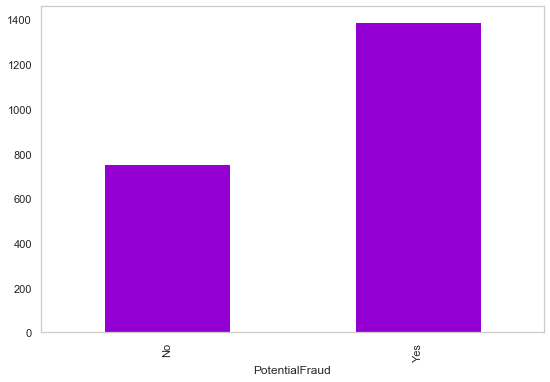

In [306]:
patient_record.groupby('PotentialFraud')['InscClaimAmtReimbursed'].mean().plot.bar(color = 'Darkviolet')


In [307]:
Reim = patient_record.groupby('Provider')['InscClaimAmtReimbursed'].mean().reset_index(name = 'InscClaimAmtReimbursed')

In [308]:
provider2 = provider2.merge(Reim, how = 'left', on = 'Provider')

Text(0.5, 0, 'Mean Inpatient Deductable amount in dollars')

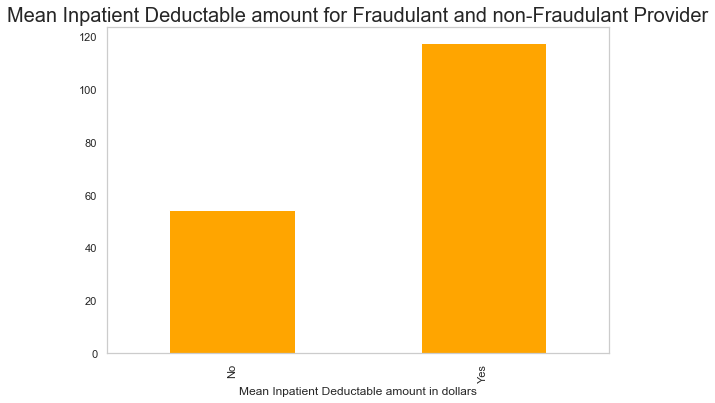

In [309]:
patient_record.groupby('PotentialFraud')['DeductibleAmtPaid'].mean().plot.bar(color = 'orange')
plt.title('Mean Inpatient Deductable amount for Fraudulant and non-Fraudulant Provider', fontsize = 20)
plt.xlabel('Mean Inpatient Deductable amount in dollars')

In [310]:
deduct = patient_record.groupby('Provider')['DeductibleAmtPaid'].mean().reset_index(name = 'DeductibleAmtPaid')

In [311]:
provider2 = provider2.merge(deduct, how = 'left', on = 'Provider')

Text(0.5, 0, 'Mean Inpatient Reimbursed amount in dollars')

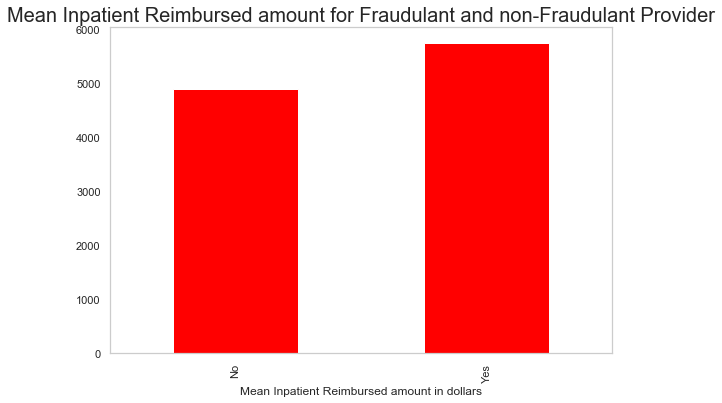

In [312]:
patient_record.groupby('PotentialFraud')['IPAnnualReimbursementAmt'].mean().plot.bar(color = 'red')
plt.title('Mean Inpatient Reimbursed amount for Fraudulant and non-Fraudulant Provider', fontsize = 20)
plt.xlabel('Mean Inpatient Reimbursed amount in dollars')

In [313]:
patient_record.groupby('PotentialFraud')['IPAnnualReimbursementAmt'].mean()

PotentialFraud
No     4903.940535
Yes    5753.945375
Name: IPAnnualReimbursementAmt, dtype: float64

[Text(0.5, 0, 'Inpatient Annual Reimbursement Amount in dollars')]

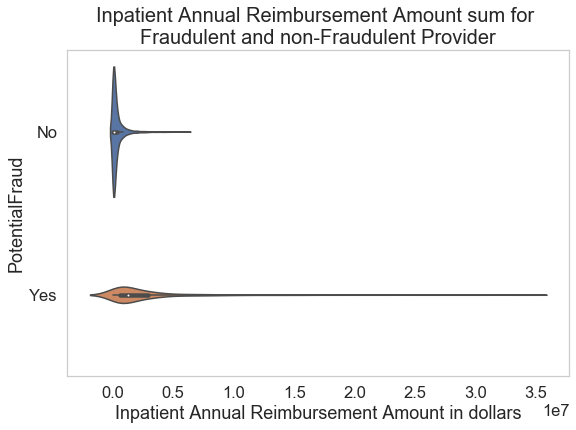

In [572]:
plt.rcParams['figure.figsize'] = (9,6)
sns.set_style("whitegrid", {'axes.grid' : False})

IP_re = patient_record.groupby(['PotentialFraud', 'Provider'])['IPAnnualReimbursementAmt'].sum().reset_index(name = 'meanIPRe')
ax = sns.violinplot(data = IP_re, y = 'PotentialFraud', x = 'meanIPRe' )
ax.set_title('Inpatient Annual Reimbursement Amount sum for \nFraudulent and non-Fraudulent Provider', fontsize = 20)
ax.set(xlabel = 'Inpatient Annual Reimbursement Amount in dollars')

[Text(0.5, 0, 'Inpatient Annual Deductable Amount in dollars')]

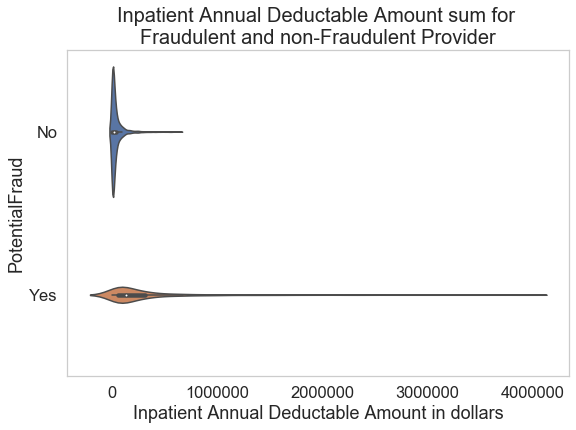

In [573]:
IP_de = patient_record.groupby(['PotentialFraud', 'Provider'])['IPAnnualDeductibleAmt'].sum().reset_index(name = 'meanIPde')
ax = sns.violinplot(data = IP_de, y = 'PotentialFraud', x = 'meanIPde' )
ax.set_title('Inpatient Annual Deductable Amount sum for \nFraudulent and non-Fraudulent Provider', fontsize = 20)
ax.set(xlabel = 'Inpatient Annual Deductable Amount in dollars')

In [316]:
IP_de

,PotentialFraud,Provider,meanIPde
0,No,PRV51001,22428
1,No,PRV51004,64808
2,No,PRV51007,32040
3,No,PRV51008,26700
4,No,PRV51011,39108
...,...,...,...
5405,Yes,PRV57642,153792
5406,Yes,PRV57667,11680
5407,Yes,PRV57672,180412
5408,Yes,PRV57697,92372


In [317]:
Fraud = patient_record.loc[patient_record.PotentialFraud == 'Yes']
non_Fraud = patient_record.loc[patient_record.PotentialFraud == 'No']

In [318]:
IP_reim = patient_record.groupby('Provider')['IPAnnualReimbursementAmt'].mean()\
        .reset_index(name = 'IPAnnualReimbursementAmt')

In [319]:
IP_re

,PotentialFraud,Provider,meanIPRe
0,No,PRV51001,440150
1,No,PRV51004,648430
2,No,PRV51007,219600
3,No,PRV51008,283460
4,No,PRV51011,256060
...,...,...,...
5405,Yes,PRV57642,1708400
5406,Yes,PRV57667,76420
5407,Yes,PRV57672,1915130
5408,Yes,PRV57697,825360


In [320]:
provider2 = provider2.merge(IP_reim, how = 'left', on = 'Provider')

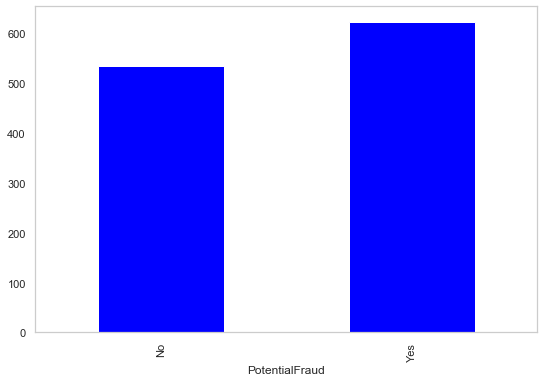

In [321]:
patient_record.groupby('PotentialFraud')['IPAnnualDeductibleAmt'].mean().plot.bar(color = 'blue')

In [322]:
IP_deduct = patient_record.groupby('Provider')['IPAnnualDeductibleAmt'].mean()\
        .reset_index(name = 'IPAnnualDeductibleAmt')

In [323]:
provider2 = provider2.merge(IP_deduct, how = 'left', on = 'Provider')

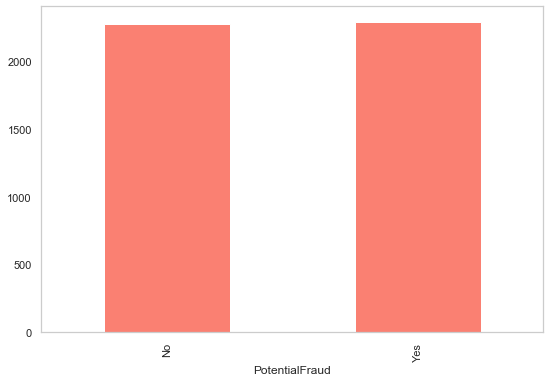

In [324]:
patient_record.groupby('PotentialFraud')['OPAnnualReimbursementAmt'].mean().plot.bar(color = 'salmon')

In [325]:
OP_reim = patient_record.groupby('Provider')['OPAnnualReimbursementAmt'].mean()\
        .reset_index(name = 'OPAnnualReimbursementAmt')

In [326]:
provider2 = provider2.merge(OP_reim, how = 'left', on = 'Provider')

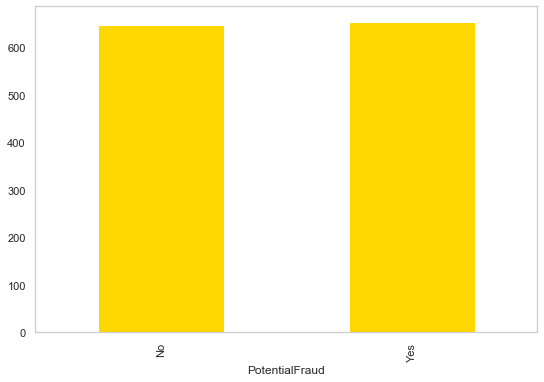

In [327]:
patient_record.groupby('PotentialFraud')['OPAnnualDeductibleAmt'].mean().plot.bar(color = 'gold')

In [328]:
OP_deduct = patient_record.groupby('Provider')['OPAnnualDeductibleAmt'].mean()\
        .reset_index(name = 'OPAnnualDeductibleAmt')

In [329]:
provider2 = provider2.merge(OP_deduct, how = 'left', on = 'Provider')

In [330]:
provider2

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,days_admitted,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0,25,2.0,4.0,3.0,2.0,5.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,4185.600000,213.600000,17606.000000,897.120000,2615.200000,463.920000
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0,132,13.0,16.0,10.0,10.0,8.0,14.0,11.0,13.0,9.0,11.0,11.0,6.0,5.0,4588.409091,502.166667,7568.181818,931.424242,2678.181818,737.121212
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0.0,4.0,149,12.0,19.0,18.0,10.0,8.0,11.0,14.0,10.0,12.0,11.0,8.0,16.0,2.0,350.134228,2.080537,4351.879195,434.953020,2194.899329,622.751678
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6,2.0,5.0,1165,102.0,101.0,113.0,98.0,83.0,103.0,92.0,99.0,107.0,111.0,73.0,83.0,2.0,241.124464,3.175966,3623.991416,379.162232,2109.733906,636.328755
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10,0.0,4.0,72,6.0,5.0,9.0,4.0,9.0,9.0,3.0,6.0,7.0,2.0,6.0,6.0,2.0,468.194444,45.333333,3050.000000,445.000000,1729.722222,469.722222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,24,outpatient,19.0,1.0,0.0,4.0,13.0,11.0,73.0,1,1,0.0,5.0,28,6.0,1.0,2.0,2.0,4.0,3.0,3.0,1.0,2.0,1.0,2.0,1.0,3.0,380.000000,4.642857,3962.142857,457.714286,3241.785714,886.785714
5406,PRV57760,No,9,outpatient,7.0,2.0,0.0,0.0,6.0,3.0,61.0,1,3,0.0,4.0,22,1.0,5.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,0.0,2.0,1.0,1.0,216.818182,0.000000,2785.454545,436.909091,1492.727273,805.454545
5407,PRV57761,No,67,outpatient,58.0,5.0,1.0,3.0,33.0,34.0,71.0,1,2,0.0,5.0,82,5.0,6.0,4.0,5.0,8.0,10.0,5.0,5.0,4.0,14.0,11.0,5.0,2.0,225.243902,4.512195,7026.585366,586.097561,2928.414634,707.317073
5408,PRV57762,No,1,outpatient,1.0,0.0,0.0,0.0,1.0,0.0,67.0,1,1,0.0,5.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1900.000000,0.000000,15000.000000,1068.000000,2540.000000,400.000000


In [331]:
patient_record['coverage'] = patient_record['InscClaimAmtReimbursed']\
                    /(patient_record['InscClaimAmtReimbursed'] + patient_record['DeductibleAmtPaid'])

In [332]:
coverage = patient_record.groupby('Provider')['coverage'].mean().reset_index(name = 'coverage')

In [333]:
provider2 = provider2.merge(coverage, how = 'left', on = 'Provider')

In [334]:
provider2

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,days_admitted,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,coverage
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0,25,2.0,4.0,3.0,2.0,5.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,4185.600000,213.600000,17606.000000,897.120000,2615.200000,463.920000,0.975656
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0,132,13.0,16.0,10.0,10.0,8.0,14.0,11.0,13.0,9.0,11.0,11.0,6.0,5.0,4588.409091,502.166667,7568.181818,931.424242,2678.181818,737.121212,0.912167
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0.0,4.0,149,12.0,19.0,18.0,10.0,8.0,11.0,14.0,10.0,12.0,11.0,8.0,16.0,2.0,350.134228,2.080537,4351.879195,434.953020,2194.899329,622.751678,0.978485
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6,2.0,5.0,1165,102.0,101.0,113.0,98.0,83.0,103.0,92.0,99.0,107.0,111.0,73.0,83.0,2.0,241.124464,3.175966,3623.991416,379.162232,2109.733906,636.328755,0.980747
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10,0.0,4.0,72,6.0,5.0,9.0,4.0,9.0,9.0,3.0,6.0,7.0,2.0,6.0,6.0,2.0,468.194444,45.333333,3050.000000,445.000000,1729.722222,469.722222,0.985303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,24,outpatient,19.0,1.0,0.0,4.0,13.0,11.0,73.0,1,1,0.0,5.0,28,6.0,1.0,2.0,2.0,4.0,3.0,3.0,1.0,2.0,1.0,2.0,1.0,3.0,380.000000,4.642857,3962.142857,457.714286,3241.785714,886.785714,0.983401
5406,PRV57760,No,9,outpatient,7.0,2.0,0.0,0.0,6.0,3.0,61.0,1,3,0.0,4.0,22,1.0,5.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,0.0,2.0,1.0,1.0,216.818182,0.000000,2785.454545,436.909091,1492.727273,805.454545,1.000000
5407,PRV57761,No,67,outpatient,58.0,5.0,1.0,3.0,33.0,34.0,71.0,1,2,0.0,5.0,82,5.0,6.0,4.0,5.0,8.0,10.0,5.0,5.0,4.0,14.0,11.0,5.0,2.0,225.243902,4.512195,7026.585366,586.097561,2928.414634,707.317073,0.935979
5408,PRV57762,No,1,outpatient,1.0,0.0,0.0,0.0,1.0,0.0,67.0,1,1,0.0,5.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1900.000000,0.000000,15000.000000,1068.000000,2540.000000,400.000000,1.000000


### Total Amount charged

In [335]:
patient_record['totalamount_charged'] = patient_record['InscClaimAmtReimbursed'] +patient_record['DeductibleAmtPaid']

In [336]:
total = patient_record.groupby('Provider')['totalamount_charged'].mean().reset_index(name = 'totalamount_charged')

In [337]:
provider2 = provider2.merge(total, how = 'left', on = 'Provider')

### Revenue(daily_charge)

In [338]:
patient_record['revenue_per_day'] = patient_record['totalamount_charged']/ patient_record['days_admitted']

In [339]:
revenue = patient_record.groupby('Provider')['revenue_per_day'].mean().reset_index(name = 'revenue_day')

In [340]:
provider2 = provider2.merge(revenue, how = 'left', on = 'Provider')

### Annual total amount

In [341]:
patient_record['annual_amount'] = patient_record['IPAnnualReimbursementAmt'] + patient_record['IPAnnualDeductibleAmt']\
                + patient_record['OPAnnualReimbursementAmt'] + patient_record['OPAnnualDeductibleAmt']

In [342]:
annual_amount = patient_record.groupby('Provider')['annual_amount'].mean().reset_index(name = 'annual_amount')

In [343]:
provider2 = provider2.merge(annual_amount, how = 'left', on = 'Provider')

## Diagnosis and procedural codes

In [344]:
patient_record.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'patient_type', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depressi

In [345]:
claimdiag = patient_record.groupby(['Provider', 'ClmAdmitDiagnosisCode'])['ClmAdmitDiagnosisCode'].count()\
            .reset_index(name = 'claimdiag')
claimdiag2 = claimdiag.groupby('Provider')['claimdiag'].count().reset_index()

In [346]:
provider2 = provider2.merge(claimdiag2, how = 'left', on = 'Provider')

In [347]:
diag_grp = patient_record.groupby(['Provider', 'DiagnosisGroupCode'])['DiagnosisGroupCode'].count()\
            .reset_index(name = 'diag_grp')
diag_grp2 = diag_grp.groupby('Provider')['diag_grp'].count().reset_index()

In [348]:
provider2 = provider2.merge(diag_grp2, how = 'left', on = 'Provider')

In [349]:
provider2[['claimdiag', 'diag_grp']] =provider2[['claimdiag', 'diag_grp']].fillna(0)

In [350]:
diagnosis = pd.DataFrame(columns = ['diag_code'])
diagnosis['diag_code'] = pd.concat([patient_record["ClmDiagnosisCode_1"],  patient_record["ClmDiagnosisCode_2"], 
                patient_record["ClmDiagnosisCode_3"], patient_record["ClmDiagnosisCode_4"],
                patient_record["ClmDiagnosisCode_5"], patient_record["ClmDiagnosisCode_6"],
                patient_record["ClmDiagnosisCode_7"],patient_record["ClmDiagnosisCode_8"],
                patient_record["ClmDiagnosisCode_9"],patient_record["ClmDiagnosisCode_10"]], axis=0)

In [351]:
#Most freq used diag codes
diagnosis.diag_code.value_counts().head(11).reset_index()

,index,diag_code
0,0,3901394
1,4019,77056
2,25000,37356
3,2724,35763
4,V5869,24904
5,4011,23773
6,42731,20138
7,V5861,20001
8,2720,18268
9,2449,17600


In [352]:
repeat_prov =pd.DataFrame(columns = ['Provider'])
repeat_prov = pd.DataFrame(pd.concat([patient_record['Provider']]*10))

In [353]:
merged_diag = pd.concat([repeat_prov, diagnosis], axis = 1)

In [354]:
DiagCode = merged_diag.groupby(['Provider', 'diag_code'])['diag_code'].count().reset_index(name = 'diag_count')

In [355]:
diag_codelst = ['4019', '25000', '2724', 'V5869', '4011', '42731', 'V5861', '2720', '2449', '4280']
merged_diag2 = merged_diag[merged_diag['diag_code'].isin(diag_codelst)]

In [356]:
DiagCode = merged_diag2.groupby(['Provider', 'diag_code'])['diag_code'].count().reset_index(name = 'diag_count')

In [357]:
diagnosis_code = DiagCode.pivot(index = 'Provider', columns = 'diag_code', values = 'diag_count')

In [358]:
diagnosis_code.columns = ['diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869', 'diag_4011', 'diag_42731', 
                         'diag_V5861','diag_2720', 'diag_2449', 'diag_4280']

In [359]:
provider2 = provider2.merge(diagnosis_code, how = 'left', on = 'Provider')

In [360]:
provider2[['diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869', 'diag_4011', 'diag_42731', 
                         'diag_V5861','diag_2720', 'diag_2449', 'diag_4280']] = \
            provider2[['diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869', 'diag_4011', 'diag_42731', 
                             'diag_V5861','diag_2720', 'diag_2449', 'diag_4280']].fillna(0)

In [361]:
provider2.head(3)

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,days_admitted,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,coverage,totalamount_charged,revenue_day,annual_amount,claimdiag,diag_grp,diag_4019,diag_25000,diag_2724,diag_V5869,diag_4011,diag_42731,diag_V5861,diag_2720,diag_2449,diag_4280
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0,25,2.0,4.0,3.0,2.0,5.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,4185.600000,213.600000,17606.000000,897.120000,2615.200000,463.920000,0.975656,4399.200000,1061.07200,21582.240000,11.0,5.0,1.0,1.0,2.0,2.0,0.0,3.0,2.0,0.0,0.0,1.0
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0,132,13.0,16.0,10.0,10.0,8.0,14.0,11.0,13.0,9.0,11.0,11.0,6.0,5.0,4588.409091,502.166667,7568.181818,931.424242,2678.181818,737.121212,0.912167,5090.575758,1298.61541,11914.909091,58.0,58.0,12.0,15.0,7.0,16.0,3.0,25.0,11.0,14.0,6.0,7.0
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0.0,4.0,149,12.0,19.0,18.0,10.0,8.0,11.0,14.0,10.0,12.0,11.0,8.0,16.0,2.0,350.134228,2.080537,4351.879195,434.953020,2194.899329,622.751678,0.978485,352.214765,250.36305,7604.483221,25.0,0.0,8.0,8.0,6.0,12.0,6.0,22.0,3.0,1.0,4.0,2.0


### Procedure codes

In [362]:
procedure = pd.DataFrame(columns = ['proc_code'])
procedure['proc_code'] = pd.concat([patient_record["ClmProcedureCode_1"],  patient_record["ClmProcedureCode_2"], 
                patient_record["ClmProcedureCode_3"], patient_record["ClmProcedureCode_4"],
                patient_record["ClmProcedureCode_5"], patient_record['ClmProcedureCode_6']], axis=0)

In [363]:
procedure.proc_code.value_counts().head(11).reset_index()

,index,proc_code
0,0.0,2761159
1,4019.0,1959
2,9904.0,1152
3,2724.0,1054
4,8154.0,1022
5,66.0,901
6,3893.0,854
7,3995.0,809
8,4516.0,651
9,3722.0,589


In [364]:
repeat_prov2 =pd.DataFrame(columns = ['Provider'])
repeat_prov2 = pd.DataFrame(pd.concat([patient_record['Provider']]*6))

In [365]:
merged_proc = pd.concat([repeat_prov2, procedure], axis = 1)

In [366]:
ProcCode = merged_proc.groupby(['Provider', 'proc_code'])['proc_code'].count().reset_index(name = 'proc_count')

In [367]:
proc_codelist = ['4019', '9904', '2724', '8154', '66', '3893', '3995', '4516', '3722', '8151']
merged_proc2 = merged_proc[merged_proc['proc_code'].isin(proc_codelist)]

In [368]:
ProcCode = merged_proc2.groupby(['Provider', 'proc_code'])['proc_code'].count().reset_index(name = 'proc_count')

In [369]:
procedure_code = ProcCode.pivot(index = 'Provider', columns = 'proc_code', values = 'proc_count')

In [370]:
procedure_code.columns = ['proc_4019', 'proc_9904', 'proc_2724', 'proc_8154', 'proc_66', 'proc_3893', 'proc_3995',
                          'proc_4516', 'proc_3722', 'proc_8151']

In [371]:
provider2 = provider2.merge(procedure_code, how = 'left', on = 'Provider')

In [372]:
provider2[['proc_4019', 'proc_9904', 'proc_2724', 'proc_8154', 'proc_66', 'proc_3893', 'proc_3995',
                          'proc_4516', 'proc_3722', 'proc_8151']] = \
            provider2[['proc_4019', 'proc_9904', 'proc_2724', 'proc_8154', 'proc_66', 'proc_3893', 'proc_3995',
                          'proc_4516', 'proc_3722', 'proc_8151']].fillna(0)

## Duplicates

In [373]:
#Duplicated_claims
duplicate_claim = patient_record[patient_record.duplicated(subset = [
                        'ClmAdmitDiagnosisCode','DiagnosisGroupCode', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5'], keep = False)]

In [374]:
duplicated_claims = duplicate_claim.groupby(['Provider'])['ClaimID'].count().reset_index(name = 'duplicate_claims')

In [375]:
provider2 = provider2.merge(duplicated_claims, how = 'left', on = 'Provider')

In [376]:
provider2[['duplicate_claims']] = provider2[['duplicate_claims']].fillna(0)

In [377]:
#Duplicated_bene_count
patient_duplicates = patient_record[patient_record.duplicated(subset = ['BeneID','Provider',
                        'ClmAdmitDiagnosisCode','DiagnosisGroupCode', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5'], keep = False)]

In [540]:
patient_duplicates.head(4)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,patient_type,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,common_patient,Age,noPhysician,chronic_count,ClaimStartMonth,days_admitted,coverage,totalamount_charged,revenue_per_day,annual_amount
34,BENE11093,CLM32146,2009-01-03,2009-01-09,PRV51842,20000,PHY341192,PHY355416,NaN,2009-01-03,4439,1068.0,2009-01-09,255,99662,2639,E8782,920,V854,4280,E9320,04185,412,42732,3950.0,2762.0,0.0,0.0,0.0,NaN,both,1922-05-01,NaN,2,1,1,6,500,12,12,0,1,1,0,1,1,1,1,1,0,0,20180,1068,33210,5858,Yes,Both,87,False,8,1,7,0.949307,21068.0,3009.714286,60316
35,BENE11093,CLM82202,2009-01-03,2009-01-12,PRV51842,20000,PHY341192,PHY355416,NaN,2009-01-03,4439,1068.0,2009-01-09,255,99662,2639,E8782,920,V854,4280,E9320,04185,412,42732,3950.0,2762.0,0.0,0.0,0.0,NaN,both,1922-05-01,NaN,2,1,1,6,500,12,12,0,1,1,0,1,1,1,1,1,0,0,20180,1068,33210,5858,Yes,Both,87,False,8,1,10,0.949307,21068.0,2106.800000,60316
3862,BENE24807,CLM31703,2008-12-31,2009-01-09,PRV54111,13000,PHY360669,PHY408812,NaN,2008-12-31,55221,1068.0,2009-01-09,345,56889,1122,40390,5185,42731,9974,4589,27801,25000,0,5369.0,0.0,0.0,0.0,0.0,NaN,both,1938-01-01,NaN,2,1,0,24,610,12,12,0,1,0,0,0,0,1,1,1,1,0,17000,2136,13320,1148,Yes,Both,70,False,5,12,10,0.924083,14068.0,1406.800000,33604
3864,BENE24807,CLM82212,2008-12-31,2009-01-11,PRV54111,13000,PHY360669,PHY408812,NaN,2008-12-31,55221,1068.0,2009-01-09,345,56889,1122,40390,5185,42731,9974,4589,27801,25000,0,5369.0,0.0,0.0,0.0,0.0,NaN,both,1938-01-01,NaN,2,1,0,24,610,12,12,0,1,0,0,0,0,1,1,1,1,0,17000,2136,13320,1148,Yes,Both,70,False,5,12,12,0.924083,14068.0,1172.333333,33604


In [379]:
patient_duplicate_count = patient_duplicates.groupby(['Provider', 'BeneID'])['BeneID'].count().\
                            reset_index(name = 'patient_duplicate_count')

In [380]:
patient_duplicate_count = patient_duplicate_count.groupby('Provider')['patient_duplicate_count'].count().reset_index()

In [381]:
provider2 = provider2.merge(patient_duplicate_count, how = 'left', on = 'Provider')

In [382]:
provider2[['patient_duplicate_count']] = provider2[['patient_duplicate_count']].fillna(0)

In [383]:
provider2.shape

(5410, 63)

In [384]:
provider2.columns

Index(['Provider', 'PotentialFraud', 'patient_count', 'patient_type', 'Race1',
       'Race2', 'Race3', 'Race5', 'Male', 'Female', 'mean_age', 'state_count',
       'phy_count', 'no_phy', 'chronic_mean', 'claim_count', 'Jan', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
       'days_admitted', 'InscClaimAmtReimbursed', 'DeductibleAmtPaid',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'coverage',
       'totalamount_charged', 'revenue_day', 'annual_amount', 'claimdiag',
       'diag_grp', 'diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869',
       'diag_4011', 'diag_42731', 'diag_V5861', 'diag_2720', 'diag_2449',
       'diag_4280', 'proc_4019', 'proc_9904', 'proc_2724', 'proc_8154',
       'proc_66', 'proc_3893', 'proc_3995', 'proc_4516', 'proc_3722',
       'proc_8151', 'duplicate_claims', 'patient_duplicate_count'],
      dtype='object')

In [385]:
provider2.head()

,Provider,PotentialFraud,patient_count,patient_type,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,days_admitted,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,coverage,totalamount_charged,revenue_day,annual_amount,claimdiag,diag_grp,diag_4019,diag_25000,diag_2724,diag_V5869,diag_4011,diag_42731,diag_V5861,diag_2720,diag_2449,diag_4280,proc_4019,proc_9904,proc_2724,proc_8154,proc_66,proc_3893,proc_3995,proc_4516,proc_3722,proc_8151,duplicate_claims,patient_duplicate_count
0,PRV51001,No,24,both,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0,25,2.0,4.0,3.0,2.0,5.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,4185.600000,213.600000,17606.000000,897.120000,2615.200000,463.920000,0.975656,4399.200000,1061.072000,21582.240000,11.0,5.0,1.0,1.0,2.0,2.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0
1,PRV51003,Yes,117,both,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0,132,13.0,16.0,10.0,10.0,8.0,14.0,11.0,13.0,9.0,11.0,11.0,6.0,5.0,4588.409091,502.166667,7568.181818,931.424242,2678.181818,737.121212,0.912167,5090.575758,1298.615410,11914.909091,58.0,58.0,12.0,15.0,7.0,16.0,3.0,25.0,11.0,14.0,6.0,7.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,0.0,2.0,0.0,25.0,0.0
2,PRV51004,No,138,outpatient,113.0,20.0,5.0,0.0,45.0,93.0,72.0,9,38,0.0,4.0,149,12.0,19.0,18.0,10.0,8.0,11.0,14.0,10.0,12.0,11.0,8.0,16.0,2.0,350.134228,2.080537,4351.879195,434.953020,2194.899329,622.751678,0.978485,352.214765,250.363050,7604.483221,25.0,0.0,8.0,8.0,6.0,12.0,6.0,22.0,3.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0
3,PRV51005,Yes,495,outpatient,382.0,110.0,3.0,0.0,208.0,287.0,70.0,4,6,2.0,5.0,1165,102.0,101.0,113.0,98.0,83.0,103.0,92.0,99.0,107.0,111.0,73.0,83.0,2.0,241.124464,3.175966,3623.991416,379.162232,2109.733906,636.328755,0.980747,244.300429,196.533055,6749.216309,158.0,0.0,30.0,54.0,31.0,74.0,62.0,140.0,23.0,18.0,47.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,530.0,2.0
4,PRV51007,No,58,both,47.0,11.0,0.0,0.0,27.0,31.0,69.0,2,10,0.0,4.0,72,6.0,5.0,9.0,4.0,9.0,9.0,3.0,6.0,7.0,2.0,6.0,6.0,2.0,468.194444,45.333333,3050.000000,445.000000,1729.722222,469.722222,0.985303,513.527778,243.681944,5694.444444,17.0,3.0,6.0,6.0,1.0,5.0,3.0,10.0,2.0,1.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0


In [386]:
#drop the monthes 
provider2 = provider2.drop(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                           axis = 1)

In [387]:
provider2.to_csv('provider2.csv')

In [388]:
patient_record.InscClaimAmtReimbursed.sum()/patient_record.ClaimID.count()

997.0121334047519

In [389]:
patient_record.to_csv('patient_record.csv')

In [390]:
provider2.columns

Index(['Provider', 'PotentialFraud', 'patient_count', 'patient_type', 'Race1',
       'Race2', 'Race3', 'Race5', 'Male', 'Female', 'mean_age', 'state_count',
       'phy_count', 'no_phy', 'chronic_mean', 'claim_count', 'days_admitted',
       'InscClaimAmtReimbursed', 'DeductibleAmtPaid',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'coverage',
       'totalamount_charged', 'revenue_day', 'annual_amount', 'claimdiag',
       'diag_grp', 'diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869',
       'diag_4011', 'diag_42731', 'diag_V5861', 'diag_2720', 'diag_2449',
       'diag_4280', 'proc_4019', 'proc_9904', 'proc_2724', 'proc_8154',
       'proc_66', 'proc_3893', 'proc_3995', 'proc_4516', 'proc_3722',
       'proc_8151', 'duplicate_claims', 'patient_duplicate_count'],
      dtype='object')

In [391]:
patient_type = pd.get_dummies(provider2['patient_type'], drop_first = True)

In [392]:
provider2 = pd.concat([provider2, patient_type], axis = 1).drop(['patient_type'], axis = 1)

In [393]:
provider2["coverage"].fillna(provider2["coverage"].mode()[0], inplace = True)

In [394]:
provider2['PotentialFraud'] = [1 if x == 'Yes' else 0 for x in provider2['PotentialFraud']]

In [193]:
from sklearn.metrics import recall_score, precision_score,confusion_matrix,\
        roc_auc_score, f1_score, plot_roc_curve, roc_curve, RocCurveDisplay, auc, precision_recall_curve,\
        fbeta_score, accuracy_score
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier,GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [180]:
#Imbalanced learn packages
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE #Synthetic Minority Oversampling Technique
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler

In [185]:
x = provider2.drop(['Provider','PotentialFraud'],axis=1)
y = provider2['PotentialFraud']
# train-test split
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(x), y, test_size=0.3, random_state=100)


In [186]:
#Undersampling via Edited Nearest Neighbors
en = EditedNearestNeighbours()
x_en, y_en = en.fit_resample(x, y)


In [191]:
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(StandardScaler().fit_transform(x_en), y_en, 
                                                                test_size=0.3, random_state=100)

In [195]:
def evaluate_model(X_train, X_test, y_train, y_test):
    classifiers = [LogisticRegression(penalty='l1', solver='liblinear'),LogisticRegressionCV(cv = 5, penalty='l1',solver='liblinear'),
                   LinearSVC(),GaussianNB(),LinearDiscriminantAnalysis(),RandomForestClassifier(),
                   GradientBoostingClassifier(),XGBClassifier()]
    
    for classifier in classifiers:
    
        model = Pipeline(steps = [('classifier', classifier)])
    
        model.fit(X_train, y_train)
        
        predicted_train = model.predict(X_train)
        predicted_test = model.predict(X_test)
    
    
        print(type(classifier).__name__)
        #print('Accuracy Score for train data: {:.3f}'.format(accuracy_score(y_train, predicted_train)))
        print('Accuracy Score for test data: {:.3f}'.format(accuracy_score(y_test, predicted_test)))
        #print('Recall Score for train data {:.3f}'.format(recall_score(y_train, predicted_train)))
        print('Recall Score for test data {:.3f}'.format(recall_score(y_test, predicted_test)))
        #print('fbeta2_score for train data{:.3f}'.format(fbeta_score(y_train, predicted_train, beta = 2)))
        print('fbeta2_score for test data{:.3f}'.format(fbeta_score(y_test, predicted_test, beta = 2)))
        #print('ROC-AUC Score for train data: {:.3f}'.format(roc_auc_score(y_train, predicted_train)))
        print('ROC-AUC Score for test data: {:.3f}'.format(roc_auc_score(y_test, predicted_test)))
        #print('Confusion matrix for train data')
        #print(confusion_matrix(y_train, predicted_train))
        print('Confusion matrix for test data')
        print(confusion_matrix(y_test, predicted_test))
        print('-' *50)


In [196]:
print(evaluate_model(X_train_en, X_test_en, y_train_en, y_test_en))

LogisticRegression
Accuracy Score for test data: 0.946
Recall Score for test data 0.589
fbeta2_score for test data0.629
ROC-AUC Score for test data: 0.789
Confusion matrix for test data
[[1248   14]
 [  62   89]]
--------------------------------------------------
LogisticRegressionCV
Accuracy Score for test data: 0.946
Recall Score for test data 0.583
fbeta2_score for test data0.623
ROC-AUC Score for test data: 0.786
Confusion matrix for test data
[[1248   14]
 [  63   88]]
--------------------------------------------------


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC
Accuracy Score for test data: 0.944
Recall Score for test data 0.543
fbeta2_score for test data0.589
ROC-AUC Score for test data: 0.768
Confusion matrix for test data
[[1252   10]
 [  69   82]]
--------------------------------------------------
GaussianNB
Accuracy Score for test data: 0.923
Recall Score for test data 0.675
fbeta2_score for test data0.666
ROC-AUC Score for test data: 0.814
Confusion matrix for test data
[[1202   60]
 [  49  102]]
--------------------------------------------------
LinearDiscriminantAnalysis
Accuracy Score for test data: 0.938
Recall Score for test data 0.530
fbeta2_score for test data0.571
ROC-AUC Score for test data: 0.758
Confusion matrix for test data
[[1245   17]
 [  71   80]]
--------------------------------------------------
RandomForestClassifier
Accuracy Score for test data: 0.944
Recall Score for test data 0.596
fbeta2_score for test data0.632
ROC-AUC Score for test data: 0.791
Confusion matrix for test data
[[1244   18]
 [  61   90]]


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier
Accuracy Score for test data: 0.946
Recall Score for test data 0.623
fbeta2_score for test data0.655
ROC-AUC Score for test data: 0.803
Confusion matrix for test data
[[1242   20]
 [  57   94]]
--------------------------------------------------
None


In [230]:
Fraud.head(2)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,patient_type,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,common_patient,Age,noPhysician,chronic_count,ClaimStartMonth,days_admitted,coverage,totalamount_charged,revenue_per_day,annual_amount
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,0,0.0,0.0,0.0,0.0,0.0,NaN,both,1943-01-01,NaN,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,Yes,Both,66,False,7,4,7,0.960544,27068.0,3866.857143,39334
5,BENE11017,CLM70950,2009-10-06,2009-10-12,PRV54986,8000,PHY402711,PHY402711,PHY402711,2009-10-06,1749,1068.0,2009-10-12,597,1745,V4571,78702,28521,7019,1963,2948,25000,25002,0,863.0,0.0,0.0,0.0,0.0,NaN,both,1940-06-01,NaN,2,1,0,31,270,12,12,1,1,1,1,1,0,1,1,0,1,1,22000,2136,1400,840,Yes,Both,69,False,9,10,7,0.882223,9068.0,1295.428571,26376


In [232]:
Fraud.noPhysician.value_counts()

False    212244
True        552
Name: noPhysician, dtype: int64

In [395]:
cd = Fraud.groupby(['Provider', 'ClmAdmitDiagnosisCode'])['ClmAdmitDiagnosisCode'].count()\
            .reset_index(name = 'claimdiag')
claimdiag2 = claimdiag.groupby('Provider')['claimdiag'].count().reset_index()

In [396]:
dg = Fraud.groupby(['Provider', 'DiagnosisGroupCode'])['DiagnosisGroupCode'].count()\
            .reset_index(name = 'diag_grp')
dg= diag_grp.groupby('Provider')['diag_grp'].count().reset_index()

In [397]:
dg

,Provider,diag_grp
0,PRV51001,5
1,PRV51003,58
2,PRV51007,3
3,PRV51008,2
4,PRV51011,1
...,...,...
2087,PRV57719,4
2088,PRV57728,1
2089,PRV57729,10
2090,PRV57732,11


In [405]:
prv = Fraud.merge(dg, how = 'left', on = 'Provider')

In [406]:
prv[['diag_grp']] =prv[['diag_grp']].fillna(0)

In [409]:
dg1 = pd.DataFrame(columns = ['diag_code'])
dg1['diag_code'] = pd.concat([Fraud["ClmDiagnosisCode_1"],  Fraud["ClmDiagnosisCode_2"], 
                Fraud["ClmDiagnosisCode_3"], Fraud["ClmDiagnosisCode_4"],
                Fraud["ClmDiagnosisCode_5"], Fraud["ClmDiagnosisCode_6"],
                Fraud["ClmDiagnosisCode_7"],Fraud["ClmDiagnosisCode_8"],
                Fraud["ClmDiagnosisCode_9"],Fraud["ClmDiagnosisCode_10"]], axis=0)

In [428]:
dg1 = dg1.diag_code.value_counts().head(11).reset_index()

In [435]:
dg2 = pd.DataFrame(columns = ['diag_code'])
dg2['diag_code'] = pd.concat([non_Fraud["ClmDiagnosisCode_1"],  non_Fraud["ClmDiagnosisCode_2"], 
                non_Fraud["ClmDiagnosisCode_3"], non_Fraud["ClmDiagnosisCode_4"],
                non_Fraud["ClmDiagnosisCode_5"], non_Fraud["ClmDiagnosisCode_6"],
                non_Fraud["ClmDiagnosisCode_7"],non_Fraud["ClmDiagnosisCode_8"],
                non_Fraud["ClmDiagnosisCode_9"],non_Fraud["ClmDiagnosisCode_10"]], axis=0)

In [436]:
dg2 = dg2.diag_code.value_counts().head(12).reset_index()

In [437]:
dg2['ratio'] = dg2['diag_code']/len(non_Fraud)

In [438]:
dg2

,index,diag_code,ratio
0,0,2457632,7.115012
1,4019,46027,0.133251
2,25000,22269,0.064470
3,2724,21073,0.061008
4,V5869,15788,0.045707
5,4011,15121,0.043776
6,V5861,12372,0.035818
7,42731,11440,0.033120
8,2720,11147,0.032271
9,2449,10324,0.029889


In [439]:
dg1['ratio'] = dg1['diag_code']/len(Fraud)
dg1

,index,diag_code,ratio
0,0,1443762,6.784723
1,4019,31029,0.145816
2,25000,15087,0.070899
3,2724,14690,0.069033
4,V5869,9116,0.042839
5,42731,8698,0.040875
6,4011,8652,0.040659
7,V5861,7629,0.035851
8,2449,7276,0.034192
9,2720,7121,0.033464


In [502]:
dg3 = dg1.merge(dg2, how = 'left', on = 'index')

In [503]:
dg3.rename(columns = {'ratio_x' : 'fraud_dgratio'}, inplace = True)

In [504]:
dg3.rename(columns = {'ratio_y' : 'nonfraud_dgratio'}, inplace = True)

In [505]:
dg3

,index,diag_code_x,fraud_dgratio,diag_code_y,nonfraud_dgratio
0,0,1443762,6.784723,2457632,7.115012
1,4019,31029,0.145816,46027,0.133251
2,25000,15087,0.070899,22269,0.064470
3,2724,14690,0.069033,21073,0.061008
4,V5869,9116,0.042839,15788,0.045707
5,42731,8698,0.040875,11440,0.033120
6,4011,8652,0.040659,15121,0.043776
7,V5861,7629,0.035851,12372,0.035818
8,2449,7276,0.034192,10324,0.029889
9,2720,7121,0.033464,11147,0.032271


In [506]:
dg3 = dg3.iloc[1:]
dg3

,index,diag_code_x,fraud_dgratio,diag_code_y,nonfraud_dgratio
1,4019,31029,0.145816,46027,0.133251
2,25000,15087,0.070899,22269,0.064470
3,2724,14690,0.069033,21073,0.061008
4,V5869,9116,0.042839,15788,0.045707
5,42731,8698,0.040875,11440,0.033120
6,4011,8652,0.040659,15121,0.043776
7,V5861,7629,0.035851,12372,0.035818
8,2449,7276,0.034192,10324,0.029889
9,2720,7121,0.033464,11147,0.032271
10,4280,7115,0.033436,8392,0.024295


In [507]:
dg4 = dg3[['index', 'nonfraud_dgratio', 'fraud_dgratio']].set_index('index')
dg4

,nonfraud_dgratio,fraud_dgratio
index,,
4019,0.133251,0.145816
25000,0.064470,0.070899
2724,0.061008,0.069033
V5869,0.045707,0.042839
42731,0.033120,0.040875
4011,0.043776,0.040659
V5861,0.035818,0.035851
2449,0.029889,0.034192
2720,0.032271,0.033464


Text(0, 0.5, 'Ratio')

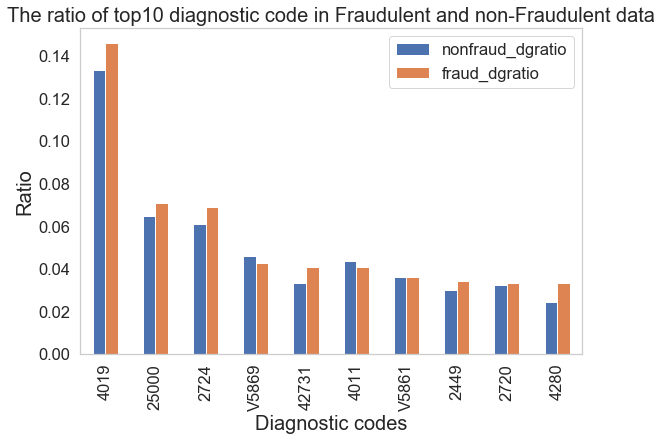

In [575]:
dg4.plot.bar()
plt.title('The ratio of top10 diagnostic code in Fraudulent and non-Fraudulent data', fontsize = 20)
plt.xlabel('Diagnostic codes', fontsize = 20)
plt.ylabel('Ratio', fontsize = 20)


In [523]:
pr1 = pd.DataFrame(columns = ['proc_code'])
pr1['proc_code'] = pd.concat([Fraud["ClmProcedureCode_1"],  Fraud["ClmProcedureCode_2"], 
                Fraud["ClmProcedureCode_3"], Fraud["ClmProcedureCode_4"],
                Fraud["ClmProcedureCode_5"], Fraud['ClmProcedureCode_6']], axis=0)

In [524]:
pr1 = pr1.proc_code.value_counts().head(11).reset_index()

In [525]:
pr2 = pd.DataFrame(columns = ['proc_code'])
pr2['proc_code'] = pd.concat([non_Fraud["ClmProcedureCode_1"],  non_Fraud["ClmProcedureCode_2"], 
                non_Fraud["ClmProcedureCode_3"], non_Fraud["ClmProcedureCode_4"],
                non_Fraud["ClmProcedureCode_5"], non_Fraud['ClmProcedureCode_6']], axis=0)

In [526]:
pr2 = pr2.proc_code.value_counts().head(11).reset_index()

In [527]:
pr1['ratio'] = pr1['proc_code']/len(Fraud)

pr2['ratio'] = pr2['proc_code']/len(non_Fraud)


In [528]:
pr3 = pr1.merge(pr2, how = 'left', on = 'index')

In [529]:
pr3 = pr3.iloc[1:]
pr3.rename(columns = {'ratio_x' : 'fraud_prratio'}, inplace = True)
pr3.rename(columns = {'ratio_y' : 'nonfraud_prratio'}, inplace = True)

In [530]:
pr3

,index,proc_code_x,fraud_prratio,proc_code_y,nonfraud_prratio
1,4019.0,1139,0.005353,820,0.002374
2,2724.0,641,0.003012,413,0.001196
3,9904.0,634,0.002979,518,0.001500
4,8154.0,615,0.002890,407,0.001178
5,66.0,539,0.002533,362,0.001048
6,3893.0,483,0.002270,371,0.001074
7,3995.0,477,0.002242,332,0.000961
8,4516.0,370,0.001739,281,0.000814
9,3722.0,334,0.001570,255,0.000738
10,8151.0,281,0.001321,182,0.000527


In [531]:
pr4 = pr3[['index', 'nonfraud_prratio', 'fraud_prratio']].set_index('index')
pr4

,nonfraud_prratio,fraud_prratio
index,,
4019.0,0.002374,0.005353
2724.0,0.001196,0.003012
9904.0,0.001500,0.002979
8154.0,0.001178,0.002890
66.0,0.001048,0.002533
3893.0,0.001074,0.002270
3995.0,0.000961,0.002242
4516.0,0.000814,0.001739
3722.0,0.000738,0.001570


Text(0, 0.5, 'Ratio')

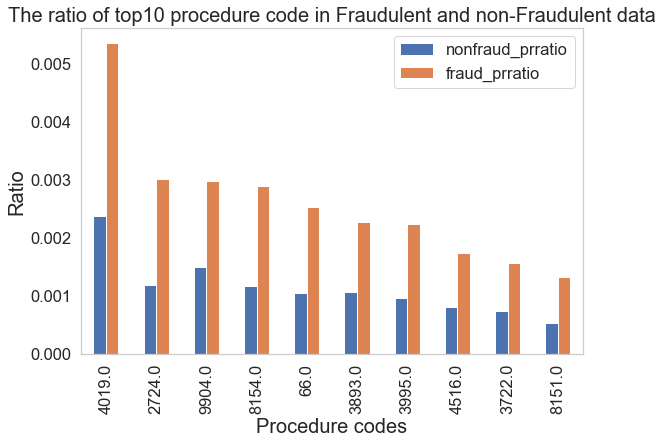

In [574]:
pr4.plot.bar()
plt.title('The ratio of top10 procedure code in Fraudulent and non-Fraudulent data', fontsize = 20)
plt.xlabel('Procedure codes', fontsize = 20)
plt.ylabel('Ratio', fontsize = 20)


In [534]:
provider2.columns

Index(['Provider', 'PotentialFraud', 'patient_count', 'Race1', 'Race2',
       'Race3', 'Race5', 'Male', 'Female', 'mean_age', 'state_count',
       'phy_count', 'no_phy', 'chronic_mean', 'claim_count', 'days_admitted',
       'InscClaimAmtReimbursed', 'DeductibleAmtPaid',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'coverage',
       'totalamount_charged', 'revenue_day', 'annual_amount', 'claimdiag',
       'diag_grp', 'diag_4019', 'diag_25000', 'diag_2724', 'diag_V5869',
       'diag_4011', 'diag_42731', 'diag_V5861', 'diag_2720', 'diag_2449',
       'diag_4280', 'proc_4019', 'proc_9904', 'proc_2724', 'proc_8154',
       'proc_66', 'proc_3893', 'proc_3995', 'proc_4516', 'proc_3722',
       'proc_8151', 'duplicate_claims', 'patient_duplicate_count', 'inpatient',
       'outpatient'],
      dtype='object')

Text(0.5, 0, '')

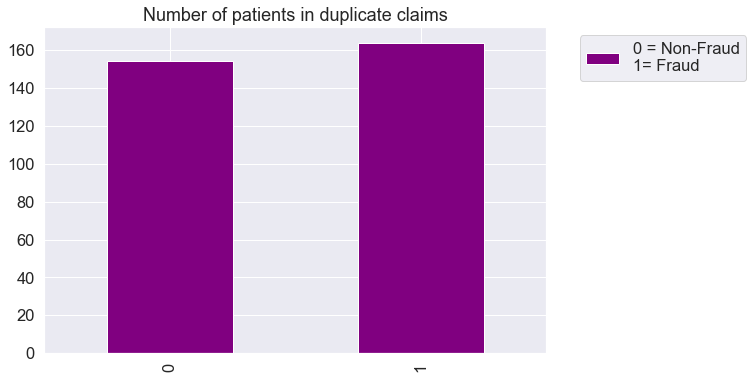

In [565]:
#patient count with duplicate claims 
sns.set(font_scale=1.5)
provider2.groupby(['PotentialFraud'])['patient_duplicate_count'].sum().plot.bar(color = 'purple')
plt.legend(['0 = Non-Fraud\n1= Fraud'], bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Number of patients in duplicate claims')
plt.xlabel('')

In [543]:
dup = pd.DataFrame({'Provider': ['From other Provider', 'Within same Provider'],
                   'Inpatients': [50,18],
                    'Outpatients' : [335,4451]
                   })

Text(0.5, 1.0, 'Duplicate claim patients Information sharing in inpatients')

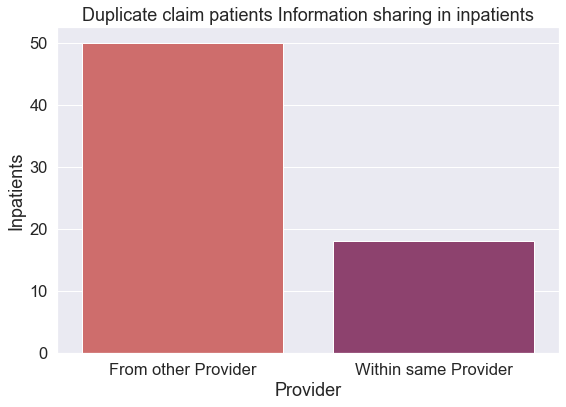

In [568]:
ax = sns.barplot(data = dup, 
                x = 'Provider', y = 'Inpatients', palette= 'flare')
ax.set_title('Duplicate claim patients Information sharing in inpatients')

Text(0.5, 1.0, 'Duplicate claim patients Information sharing in outpatients')

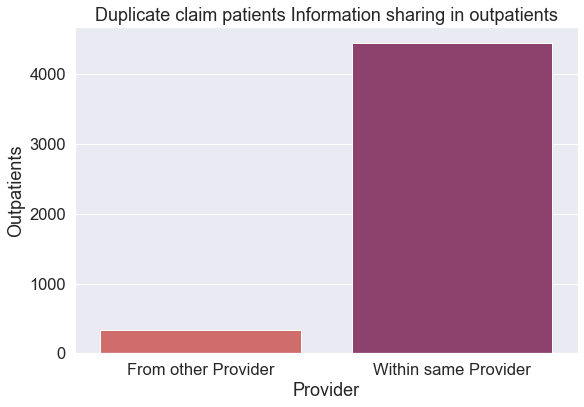

In [567]:
ax = sns.barplot(data = dup, 
                x = 'Provider', y = 'Outpatients', palette= 'flare')
ax.set_title('Duplicate claim patients Information sharing in outpatients')